# Costa Rican Household Poverty Level Prediction : Data Visualization, Feature Engineering, PCA, Estimators & Model Building

The Inter-American Development Bank is asking community for help with income qualification for some of the world's poorest families.

Here's the backstory: Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

To improve on PMT, the IDB (the largest source of development financing for Latin America and the Caribbean) has turned to the Kaggle community. They believe that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

Pseudo Code :
a. Explore data and perform data visualization

b. Fill in missing values (NULL values) either using mean or median (if the attribute is numeric) or most-frequently occurring value if the attribute is 'object' or categorical.

b. Perform feature engineering, may be using some selected features and only from numeric features.

c. Scale numeric features, AND IF REQUIRED, perform One HOT Encoding of categorical features

d. IF number of features is very large, please do not forget to do PCA.

e. Select some estimators for your work. May be select some (or all) of these:

        
        RandomForestClassifier
        GradientBoostingClassifier
        KNeighborsClassifier
        XGBoost
        LightGBM

First perform modeling with default parameter values and get accuracy.

f. Then perform tuning using Bayesian Optimization. 

In [14]:
# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [15]:
# Clear memory -  https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-reset
# Resets the namespace by removing all names defined by the user
# -f : force reset without asking for confirmation.
%reset -f

In [16]:
# Call data manipulation libraries
import pandas as pd
import numpy as np

In [17]:
# Plotting libraries to plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Read the train Data File 5 rows × 142 columns
train = pd.read_csv("../input/train.csv")
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [19]:
# Read the test Data File  5 rows × 142 columns
test = pd.read_csv("../input/test.csv")
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


It seems that there are 130 integer columns, 8 float columns, and 5 object columns.

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Integer Columns

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

For near to 100 columns, it seems that 2 unique values ( Boolean 0 or 1)

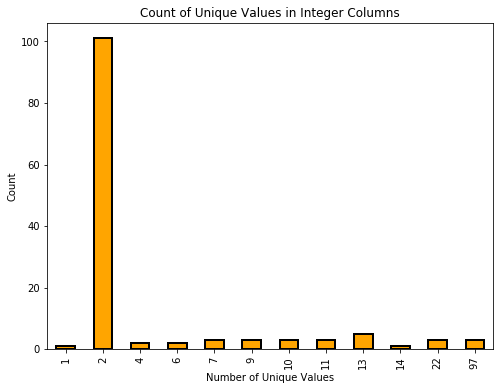

In [22]:
#https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'orange', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

There are 8 columns with Float Datatypes. 

Following graphs shows the distributions of the float columns colored by the value of the Target. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


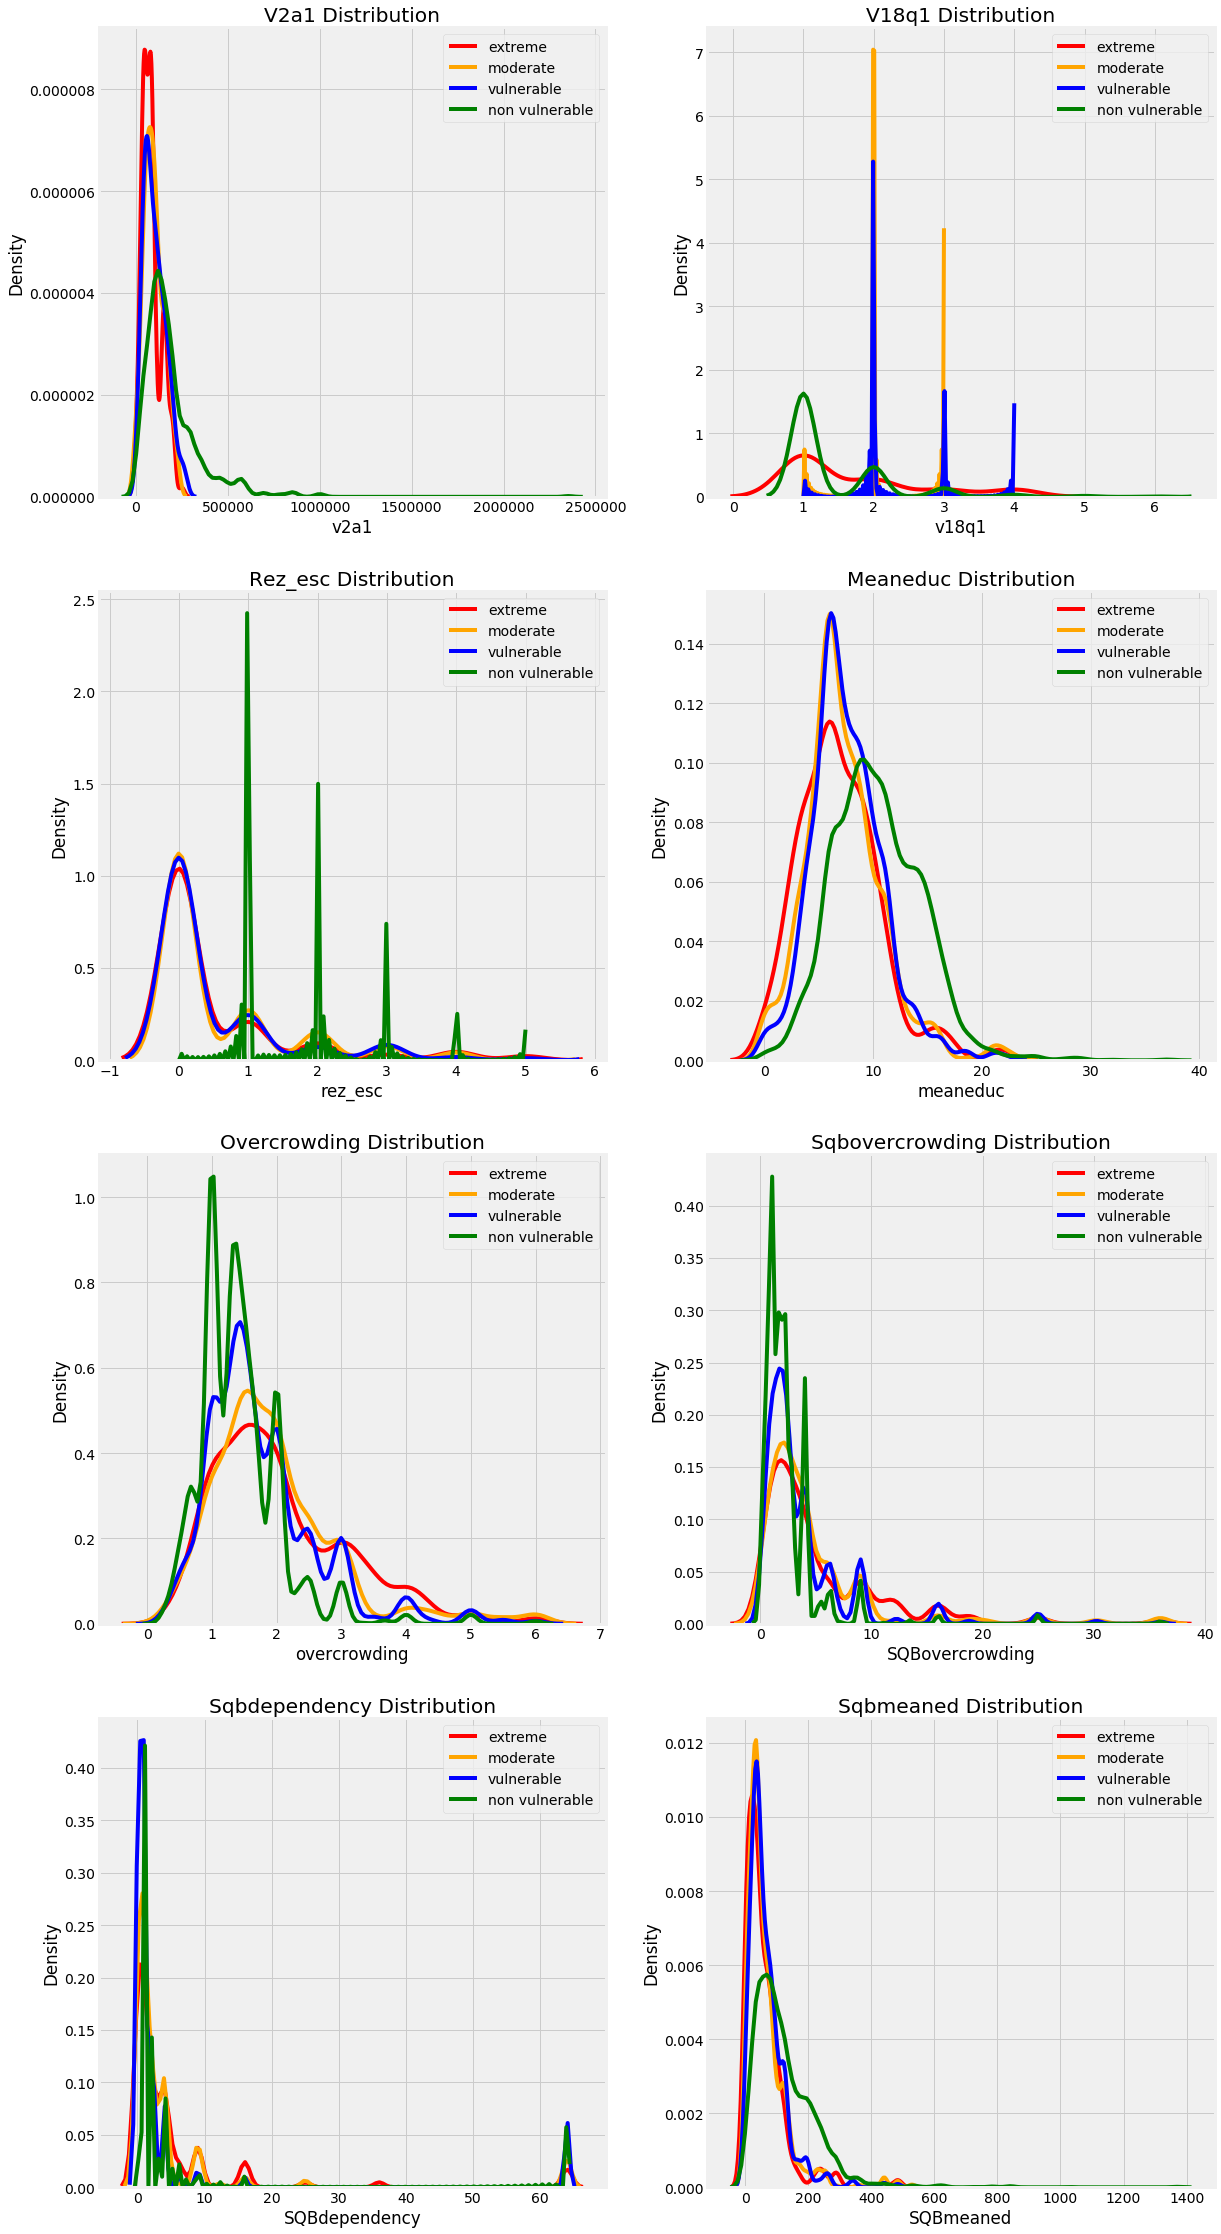

In [23]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Object Column


In [24]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no



Id - a unique identifier for each row. 

idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.

dependency - Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)

edjefe - years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

edjefa - years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

id & idhogar are seems to be identifier column. For remaining 3 object columns, we can map it to 'no' to 0 & 'yes' to 1

In [25]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


Target - the target is an ordinal variable indicating groups of income levels.
1 = extreme poverty
2 = moderate poverty
3 = vulnerable households
4 = non vulnerable households 

In [26]:
target_values = train['Target'].value_counts()
target_values = pd.DataFrame(target_values)
target_values['Household_type'] = target_values.index
mappy = {4: "NonVulnerable", 3: "Moderate Poverty", 2: "Vulnerable", 1: "Extereme Poverty"}
target_values['Household_type'] = target_values.Household_type.map(mappy)
target_values

,Target,Household_type
4,5996,NonVulnerable
2,1597,Vulnerable
3,1209,Moderate Poverty
1,755,Extereme Poverty


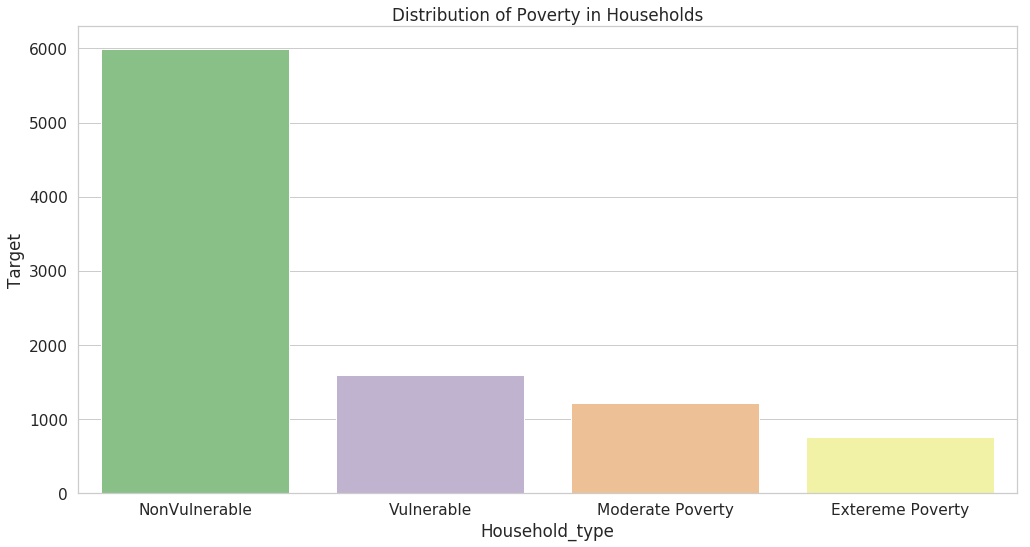

In [27]:
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x = 'Household_type', y = 'Target', data = target_values, palette='Accent', ci = None).set_title('Distribution of Poverty in Households')


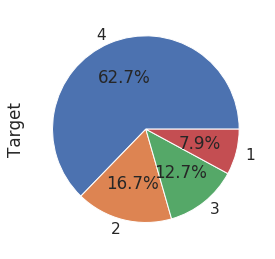

In [28]:
train['Target'].value_counts().plot(kind='pie',  autopct='%1.1f%%')

Text(0.5, 1.0, '# of Rooms in Households for Diff Proverty Class')

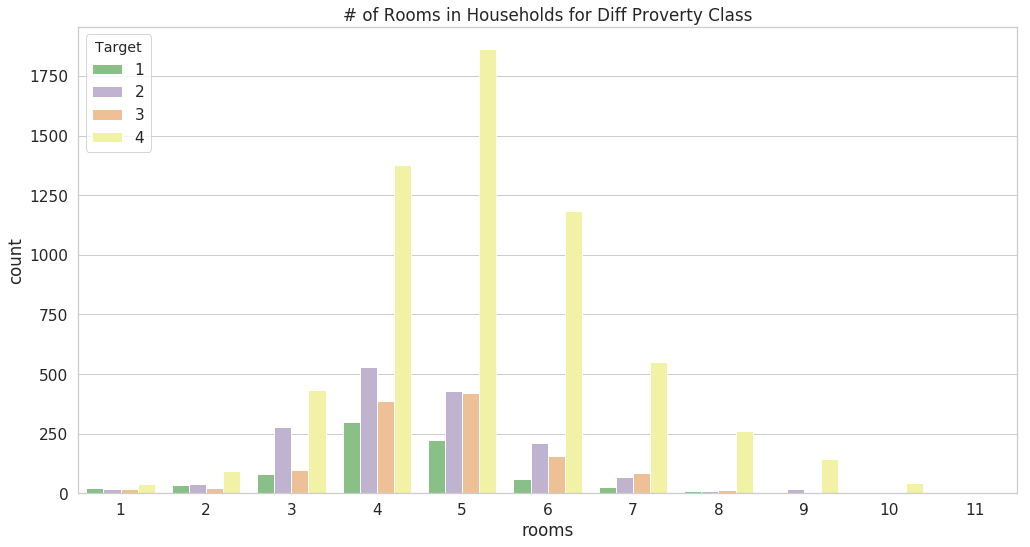

In [29]:
#sns.countplot(x="v2a1",data=train)
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(15, 8))

sns.countplot(x="rooms", hue= "Target", data=train, palette="Accent").set_title('# of Rooms in Households for Diff Proverty Class')

Text(0.5, 1.0, '# of Males in Households for Diff Proverty Class')

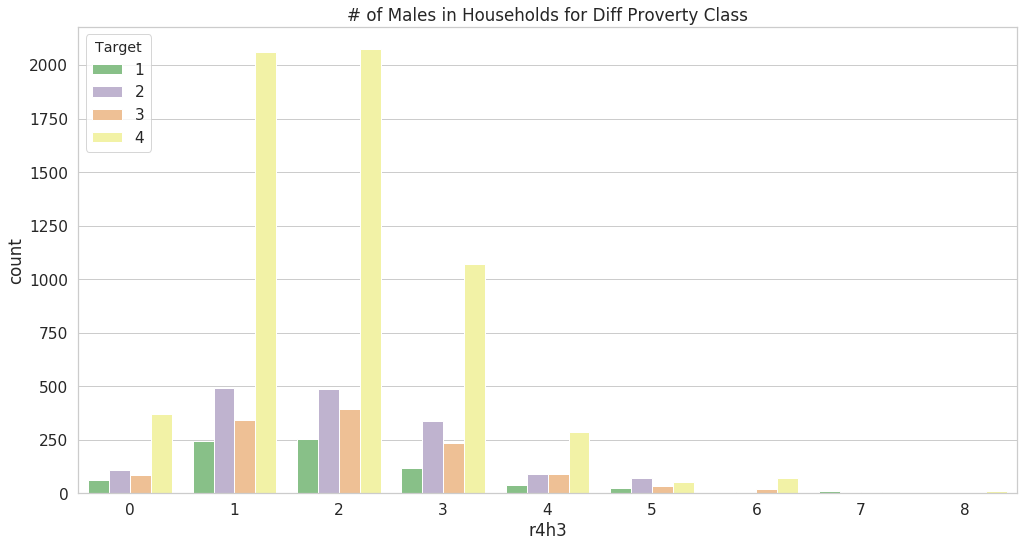

In [30]:
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(15, 8))

sns.countplot(x="r4h3", hue= "Target", data=train, palette="Accent").set_title('# of Males in Households for Diff Proverty Class')

Text(0.5, 1.0, '# of Refrigrator in Households for Diff Proverty Class')

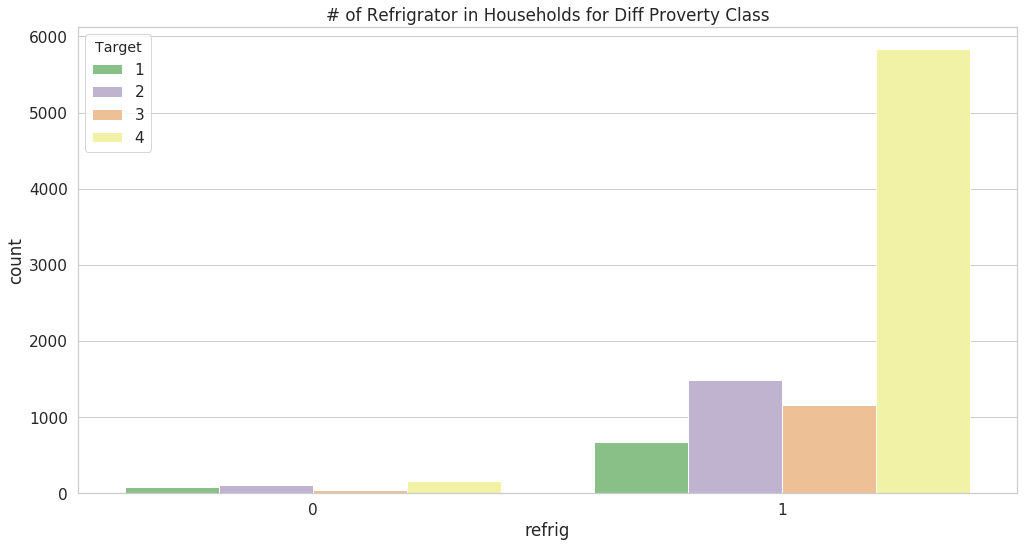

In [31]:
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(15, 8))

sns.countplot(x="refrig", hue= "Target", data=train, palette="Accent").set_title('# of Refrigrator in Households for Diff Proverty Class')

Fill in missing values (NULL values) either using mean or median (if the attribute is numeric) or most-frequently occurring value if the attribute is 'object' or categorical.

In [32]:
# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,7928,0.829549
v18q1,7342,0.768233
v2a1,6860,0.717798
SQBmeaned,5,0.000523
meaneduc,5,0.000523
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [33]:
# Number of missing in each column - Test Data
missing = pd.DataFrame(test.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(test)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,19653,0.823818
v18q1,18126,0.759809
v2a1,17403,0.729502
meaneduc,31,0.001299
SQBmeaned,31,0.001299
instlevel1,0,0.000000
edjefa,0,0.000000
edjefe,0,0.000000
dependency,0,0.000000
parentesco8,0,0.000000


same columns with missing values are observed in test!

In [34]:
train[['meaneduc', 'SQBmeaned']].describe()

,meaneduc,SQBmeaned
count,9552.000000,9552.000000
mean,9.231523,102.588867
std,4.167694,93.516890
min,0.000000,0.000000
25%,6.000000,36.000000
50%,9.000000,81.000000
75%,11.600000,134.560010
max,37.000000,1369.000000


The point is that if we observe outliers in data, we should fill in NAs with median, otherwise it's ok to fill in with mean values. In the table, 50% is the median value, mean is mean :) Here it's fine to use mean values


Other 3 columns we fill in with 0's temporarily


In [35]:
#train
train['meaneduc'].fillna(train['meaneduc'].mean(), inplace = True)
train['SQBmeaned'].fillna(train['SQBmeaned'].mean(), inplace = True)
#the same for test
test['meaneduc'].fillna(test['meaneduc'].mean(), inplace = True)
test['SQBmeaned'].fillna(test['SQBmeaned'].mean(), inplace = True)
train['rez_esc'].fillna(0, inplace = True)
train['v18q1'].fillna(0, inplace = True)
train['v2a1'].fillna(0, inplace = True)

Feature Engine

In [36]:
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['rent_to_bedrooms'] = df['v2a1']/df['bedrooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['tamhog_to_bedrooms'] = df['tamhog']/df['bedrooms']
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['r4t3_to_bedrooms'] = df['r4t3']/df['bedrooms']
    df['rent_to_r4t3'] = df['v2a1']/df['r4t3']
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1'])
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms']
    df['hhsize_to_bedrooms'] = df['hhsize']/df['bedrooms']
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize']
    df['qmobilephone_to_r4t3'] = df['qmobilephone']/df['r4t3']
    df['qmobilephone_to_v18q1'] = df['qmobilephone']/df['v18q1']
    

extract_features(train)
extract_features(test)

In [37]:
train.shape,test.shape

((9557, 158), (23856, 157))

In [38]:
# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(20)

,total,percent
qmobilephone_to_v18q1,235,0.024589
instlevel5,0,0.000000
edjefe,0,0.000000
edjefa,0,0.000000
meaneduc,0,0.000000
instlevel1,0,0.000000
instlevel2,0,0.000000
instlevel3,0,0.000000
instlevel4,0,0.000000
instlevel6,0,0.000000


In [39]:
train['qmobilephone_to_v18q1'].fillna(0, inplace = True)


test['qmobilephone_to_v18q1'].fillna(0, inplace = True)


In [40]:
# Splitting data into dependent and independent variable
# X is the independent variables matrix
X = train.drop('Target', axis = 1)

# y is the dependent variable vector
y = train.Target

In [41]:
X.drop(['Id','idhogar'], inplace = True, axis=1)
X.drop(['qmobilephone_to_v18q1'], inplace = True, axis=1)
X.shape

(9557, 154)

In [42]:
X.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,...,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,bedrooms_to_rooms,rent_to_rooms,rent_to_bedrooms,tamhog_to_rooms,tamhog_to_bedrooms,r4t3_to_tamhog,r4t3_to_rooms,r4t3_to_bedrooms,rent_to_r4t3,v2a1_to_r4t3,hhsize_to_rooms,hhsize_to_bedrooms,rent_to_hhsize,qmobilephone_to_r4t3
count,9.557000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9.557000e+03,9557.000000
mean,4.662861e+04,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,0.325416,0.385895,1.559171,1.945066,0.399184,1.661714,2.060898,0.785079,3.220885,4.005964,3.999058,4.094590,7.200272,0.078372,3.999058,0.594015,0.077744,0.188030,0.008580,0.115622,0.013079,0.001465,0.001465,0.692791,0.222873,0.000942,0.001046,0.016428,0.065920,0.970074,0.017683,0.003139,0.002197,...,0.100555,0.181647,0.017056,0.082243,0.102124,0.284608,0.975306,2.821492,0.587632,0.092707,0.062363,0.082767,0.093858,0.080674,0.714555,0.285445,34.303547,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,0.558364,9701.334887,18852.488703,0.871480,1.574516,1.003034,0.872505,1.576197,14264.128731,18122.663768,0.871480,1.574516,1.443691e+04,0.749833
std,1.091671e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.697118,0.680779,1.036574,1.188852,0.692460,0.933052,1.206172,1.047559,1.440995,1.771202,1.772216,1.876428,4.730877,0.427241,1.772216,0.491107,0.267782,0.390756,0.092235,0.319788,0.113621,0.038248,0.038248,0.461361,0.416196,0.030675,0.032332,0.127120,0.248156,0.170391,0.131805,0.055942,0.046827,...,0.300754,0.385573,0.129485,0.274750,0.302827,0.451251,0.155199,1.483249,0.492286,0.290036,0.241826,0.275543,0.291646,0.272348,0.451650,0.451650,21.612261,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.492421,1741.197050,0.120207,20368.309996,42413.546735,0.507164,0.798746,0.051007,0.506477,0.797214,38507.838259,45692.147457,0.507164,0.798746,4.160411e+04,0.365711
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.090909,0.125000,1.000000,0.090909,0.125000,0.000000,0.000000

In [43]:
# Scaling Features
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_ss = ss.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PCA

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_PCA = pca.fit_transform(X)

Split in Train and Test

In [45]:
# split into train/test and resample the data
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, random_state=1)

Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf = rf.fit(X_train, y_train)


In [47]:
y_pred = rf.predict(X_test)
y_pred

array([4, 3, 1, ..., 4, 4, 4])

In [48]:
print('    Accuracy Report: Random Forest Model\n', classification_report(y_test, y_pred))


    Accuracy Report: Random Forest Model
               precision    recall  f1-score   support

           1       0.30      0.25      0.27       183
           2       0.43      0.39      0.41       410
           3       0.37      0.31      0.33       304
           4       0.75      0.81      0.78      1493

   micro avg       0.63      0.63      0.63      2390
   macro avg       0.46      0.44      0.45      2390
weighted avg       0.61      0.63      0.62      2390



Decision Tree Classifier

In [49]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt = dt.fit(X_train, y_train)


In [50]:
y_pred1 = dt.predict(X_test)
y_pred1

array([4, 4, 4, ..., 4, 4, 4])

In [51]:
print('    Accuracy Report: Decision Tree Model\n', classification_report(y_test, y_pred1))

    Accuracy Report: Decision Tree Model
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       183
           2       0.00      0.00      0.00       410
           3       0.25      0.00      0.01       304
           4       0.62      1.00      0.77      1493

   micro avg       0.62      0.62      0.62      2390
   macro avg       0.22      0.25      0.19      2390
weighted avg       0.42      0.62      0.48      2390



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gradient Boost Classifier

In [52]:
from sklearn.ensemble import GradientBoostingClassifier as gbm

gbc = gbm()
gbc = gbc.fit(X_train, y_train)


In [53]:
y_pred2 = gbc.predict(X_test)
y_pred2

array([4, 4, 4, ..., 4, 4, 4])

In [54]:
print('    Accuracy Report: Gradient Boost Model\n', classification_report(y_test, y_pred2))


    Accuracy Report: Gradient Boost Model
               precision    recall  f1-score   support

           1       0.67      0.04      0.08       183
           2       0.61      0.06      0.10       410
           3       0.79      0.07      0.13       304
           4       0.64      0.99      0.78      1493

   micro avg       0.64      0.64      0.64      2390
   macro avg       0.67      0.29      0.27      2390
weighted avg       0.66      0.64      0.53      2390



KNeighborsClassifier

In [55]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=4)
kn = kn.fit(X_train, y_train)

In [56]:
y_pred3 = kn.predict(X_test)
y_pred3

array([4, 3, 1, ..., 4, 4, 4])

In [57]:
print(' Accuracy Report: K Neighbors Model\n', classification_report(y_test, y_pred3))

 Accuracy Report: K Neighbors Model
               precision    recall  f1-score   support

           1       0.27      0.29      0.28       183
           2       0.38      0.39      0.39       410
           3       0.34      0.25      0.29       304
           4       0.75      0.78      0.77      1493

   micro avg       0.61      0.61      0.61      2390
   macro avg       0.43      0.43      0.43      2390
weighted avg       0.60      0.61      0.60      2390



  XGBoost
 

In [58]:
from xgboost.sklearn import XGBClassifier as XGB
xgb = XGB()
xgb = xgb.fit(X_train, y_train)

In [59]:
y_pred4 = xgb.predict(X_test)
y_pred4

array([4, 4, 4, ..., 4, 4, 4])

In [60]:
print('Accuracy Report: XGB Model\n', classification_report(y_test, y_pred4))

Accuracy Report: XGB Model
               precision    recall  f1-score   support

           1       1.00      0.05      0.09       183
           2       1.00      0.03      0.05       410
           3       0.82      0.05      0.09       304
           4       0.63      1.00      0.78      1493

   micro avg       0.64      0.64      0.64      2390
   macro avg       0.86      0.28      0.25      2390
weighted avg       0.75      0.64      0.51      2390



 LightGBM

In [61]:
import lightgbm as lgb
lightgbm = lgb.LGBMClassifier()
lightgbm = lightgbm.fit(X_train, y_train)

In [62]:
y_pred5 = lightgbm.predict(X_test)
y_pred5

array([4, 4, 4, ..., 4, 4, 4])

In [63]:
print('Accuracy Report: Light GBM Model\n', classification_report(y_test, y_pred5))

Accuracy Report: Light GBM Model
               precision    recall  f1-score   support

           1       0.45      0.08      0.13       183
           2       0.61      0.12      0.21       410
           3       0.62      0.12      0.20       304
           4       0.66      0.97      0.78      1493

   micro avg       0.65      0.65      0.65      2390
   macro avg       0.59      0.32      0.33      2390
weighted avg       0.63      0.65      0.56      2390

